# BranchPro: inference of R_t

The first part of the notebook includes a forward simulation of the incidence numbers for an example branching process model. The reproduction number profile is assumed to be a step function with only one jump.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- explicit calculation;
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd

num_timepoints = 30 # number of days for incidence data


## Parameterize example branching process model

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w
m = branchpro.BranchProModel(initial_r, serial_interval)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

cases = m.simulate(parameters, times)
print(cases)

[ 100.    0.   68.  100.  128.  186.  246.  372.  490.  670.  971. 1313.
 1857. 2649. 3651. 5016. 1152. 1641. 1577. 1312. 1035.  906.  741.  632.
  527.  446.  354.  307.  255.  218.]


## Plot local incidence numbers

In [3]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Compute the posterior distribution using explicit method

In [4]:
# Posterior of R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

i=0
for t in range(R_t_start,num_timepoints):
    shape.append( a + math.fsum(cases[(t-tau):(t+1)]) )
    sum_var = 0
    for k in range(t-tau,t+1):
        vec1 = cases[(k-1)::-1] # I_(k-1), ... , I_0
        vec2 = serial_interval[:k] # w_1, ... , w_k
        sum_var += math.fsum( np.multiply(vec1,vec2) )
    rate.append( 1/b + sum_var )
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape,scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)


## Inference plot using explicit calculation results

In [5]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

interval = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': mean,
    'Lower bound CI': post_dist_interval[0],
    'Upper bound CI': post_dist_interval[1],
    'Central Probability': (L1+L2) * [0.95]
})

In [6]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using pre-computed posterior class method

In [7]:
# Same inference, but using the BranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

## Inference plot using class method results

In [8]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using sampling class method

In [9]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

inference_new = branchpro.PoissonBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau=tau,
    alpha=a,
    beta=1/b)


/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:260: RuntimeWarning:

overflow encountered in exp

/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:159: RuntimeWarning:

overflow encountered in exp



Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     15     0.333    1       0.333    1       0.5      1        0:00.0
1     18     0.25     1       0.25     1       0.25     1        0:00.0
2     21     0.25     1       0.25     1       0.25     1        0:00.0
3     24     0.25     1       0.25     1       0.25     1        0:00.0
20    456    0.761    7       0.758    8       0.764    5        0:00.6
40    1284   0.754    11      0.759    14      0.738    13       0:01.8
60    2016   0.772    12      0.744    12      0.776    12       0:02.8
80    2664   0.724    11      0.748    11      0.742    13       0:03.7
100   3157   0.739    12      0.749    13      0.742    10       0:04.3
Halting: Maximum number of iterations (100) reached.
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  --

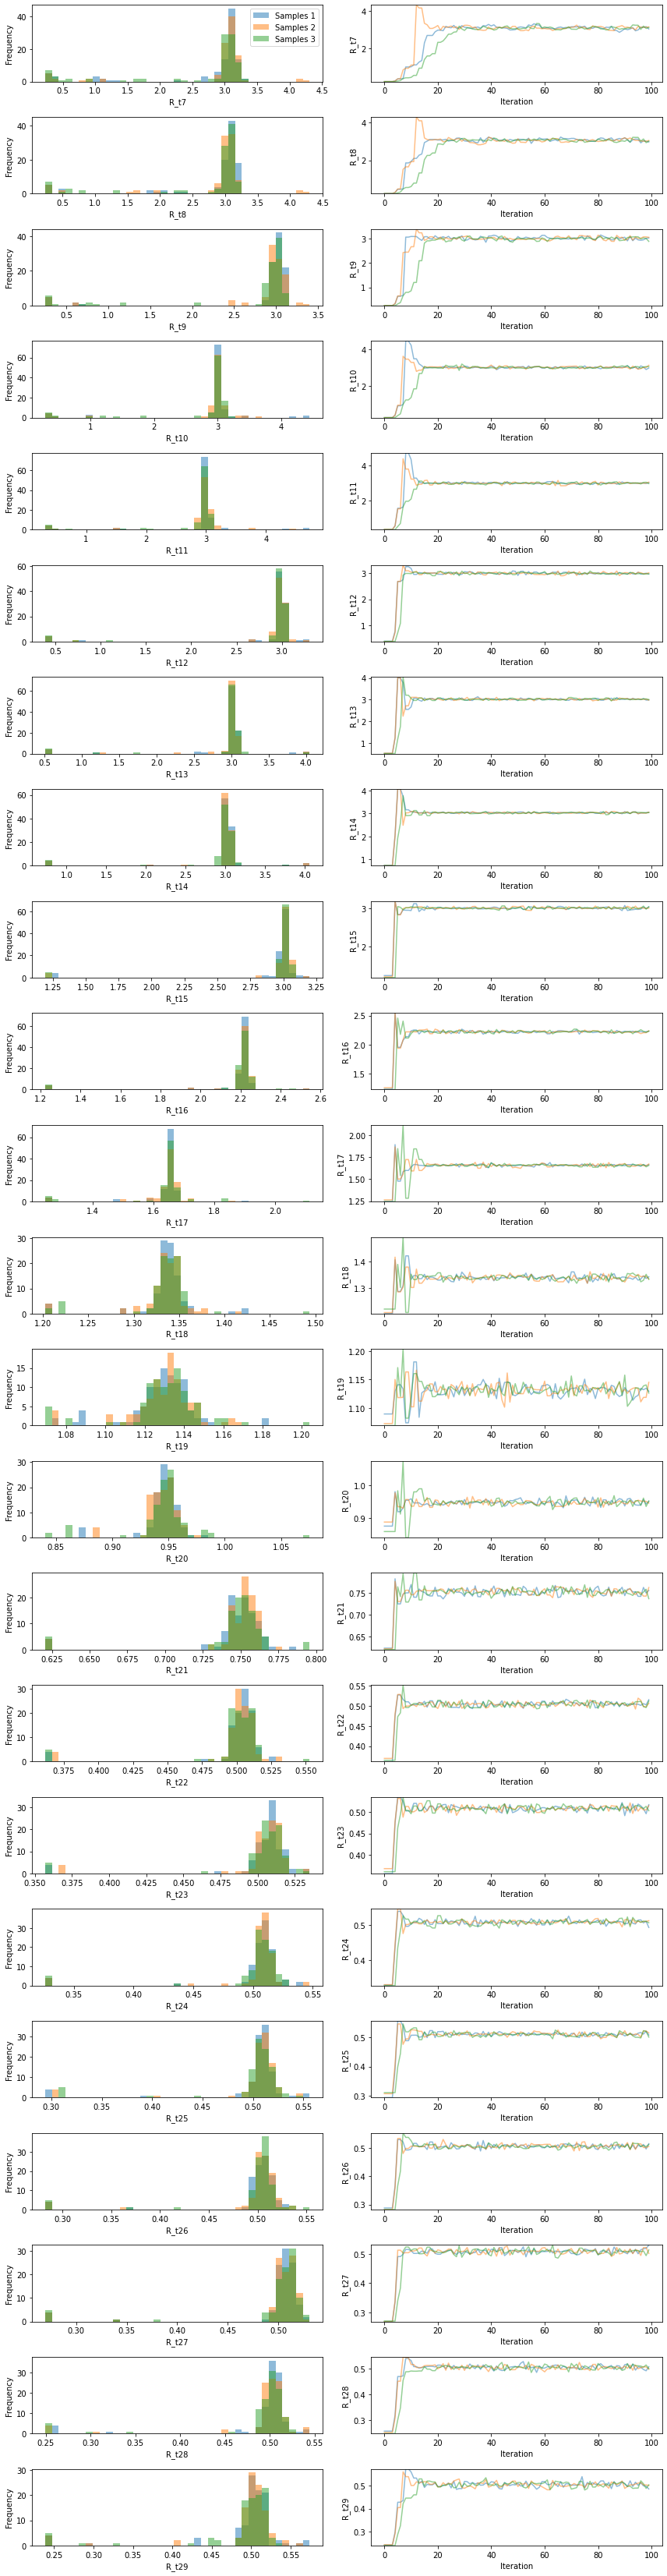

In [10]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference_new.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 50:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [11]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [12]:
dLl = []
old_r_profile = ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
    new_r_profile = old_r_profile.copy()
    new_r_profile[_] = old_r_profile[_] + 10**(-5)
    dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[14.998298138380049, 15.61865210533142, 9.557744488120079, 8.74376855790615, 0.29997900128364563, -2.780556678771972, 23.496942594647404, 39.22088071703911, 27.55937166512012, 25743.576418608423, 24135.690042749044, 21994.210639968514, 18991.38824082911, 14541.855873540042, 8495.740918442607, 159.66524370014668, 243.3749847114086, 251.248013228178, 233.11902768909928, 119.49306353926657, 130.85161335766315, 70.48151455819607, 69.25254128873348]
[14.998917638699481, 15.6195643741396, 9.558952189710908, 8.745486805853602, 0.30236216634352786, -2.777269956115333, 23.501584046641256, 39.227319105913466, 27.568366243036508, 25743.908607260608, 24136.03563682641, 21994.561498533105, 18991.72818099728, 14542.163568984355, 8495.99370262172, 159.83251652439867, 243.53186636788632, 251.3826354159355, 233.23101146590488, 119.5858845250732, 130.92989304319872, 70.5467502955753, 69.30732150846234]


In [13]:
theta_hat = inference_new.run_optimisation()[0]
S_vector = np.multiply(np.reciprocal(np.array(shape)-1), np.square(theta_hat))
S = np.diag(S_vector)

# q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta1.mean(),
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13      1157131   1157131    0:00.0
1     26      1167285   1167285    0:00.1
2     39      1171420   1171420    0:00.1
3     52      1177403   1177403    0:00.1
20    273     1212803   1208893    0:00.3
40    533     1219377   1219377    0:00.6
60    793     1221143   1220982    0:00.8
80    1053    1221500   1221500    0:01.1
100   1313    1221681   1221681    0:01.4
120   1573    1221734   1221734    0:01.6
140   1833    1221753   1221753    0:01.9
160   2093    1221756   1221756    0:02.1
180   2353    1221757   1221757    0:02.4
200   2613    1221757   1221757    0:02.6
220   2873    1221757   1221757    0:02.9
240   3133    1221757   1221757    0:03.2
260   3393    1221757   1221757    0:03.4
265   3445    1221757   1221757    0:03.5
Halting: No significant change for 100 iterations.
[3.08678265 3.0632081 

In [14]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

